# Sound Realty EDA for Model Enhancement

In [9]:
import json
import pathlib
from typing import List, Tuple
import pickle

import pandas as pd
from sklearn import model_selection, neighbors, pipeline, preprocessing, metrics
import mlflow
import mlflow.sklearn
import datetime

In [10]:
# Get data directory
base_dir = os.getcwd()

SALES_PATH = os.path.join(base_dir, "data", "kc_house_data.csv")
DEMOGRAPHICS_PATH = os.path.join(base_dir, "data", "zipcode_demographics.csv")
train_data_path = os.path.join(base_dir, "data", "future_unseen_examples.csv")

# Paths to save model outputs
OUTPUT_APP_DIR = os.path.join(BASE_DIR, "app", "model")
OUTPUT_DIR = os.path.join(BASE_DIR, "train", "model")

# Path to the SQLite database
DATABASE_PATH = os.path.join(BASE_DIR, "mlflow.db")


SALES_COLUMN_SELECTION = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'zipcode']

In [11]:
def setup_mlflow():
    """Sets up MLflow to use SQLite as the backend store."""
    if not os.path.exists(DATABASE_PATH):
        # Automatically create the SQLite database if it doesn't exist
        with open(DATABASE_PATH, 'w'):
            pass

    # Set the tracking URI to the SQLite database
    mlflow.set_tracking_uri(f"sqlite:///{DATABASE_PATH}")


def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pd.DataFrame, pd.Series]:
    """Load the target and feature data by merging sales and demographics."""
    data = pd.read_csv(sales_path,
                       usecols=sales_column_selection,
                       dtype={'zipcode': str})
    demographics = pd.read_csv(demographics_path,
                               dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    
    y = merged_data.pop('price')
    x = merged_data

    return x, y

## 1. Original Model

In [31]:
def main():
    """Load data, train model, and export artifacts."""
    # Set up MLflow with SQLite
    setup_mlflow()

    x, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, random_state=42)

    # Get the current date
    train_date = datetime.datetime.now().isoformat()

    # Start MLflow run
    with mlflow.start_run() as run:
        model = pipeline.make_pipeline(preprocessing.RobustScaler(),
                                       neighbors.KNeighborsRegressor()).fit(
                                           x_train, y_train)

        # Log model and parameters with MLflow
        mlflow.sklearn.log_model(model, "model")
        mlflow.log_params({
            "model_type": "KNeighborsRegressor",
            "n_neighbors": model.named_steps['kneighborsregressor'].n_neighbors,
            "weights": model.named_steps['kneighborsregressor'].weights,
            "algorithm": model.named_steps['kneighborsregressor'].algorithm,
            "leaf_size": model.named_steps['kneighborsregressor'].leaf_size,
            "metric": model.named_steps['kneighborsregressor'].metric,
            "p": model.named_steps['kneighborsregressor'].p,
            "train_date": train_date
        })

        # Predict and evaluate on the test set
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        # Log metrics
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        r2_test = metrics.r2_score(y_test, y_pred_test)

        mlflow.log_metric("train_score", train_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("r2_test", r2_test)

        # Register the model and get the version
        mlflow.register_model(
            f"runs:/{run.info.run_id}/model",
            "HousePricePredictionModel"
        )
        
        full_data, prices = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
        preds = model.predict(full_data)
        full_data['pred_price'] = preds
        full_data['actual_price'] = prices
        full_data['price_diff'] = full_data['actual_price'] - full_data['pred_price']
        full_data['price_diff_abs'] = abs(full_data['actual_price'] - full_data['pred_price'])
        full_data.to_csv('data_w_preds.csv')
        
        print("train_score: ", train_score)
        print("test_score: ", test_score)
        print("mae: ", mae_test)
        print("mse: ", mse_test)
        print("r2: ", r2_test)

In [32]:
main()

Registered model 'HousePricePredictionModel' already exists. Creating a new version of this model...
2024/08/19 16:34:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HousePricePredictionModel, version 8
Created version '8' of model 'HousePricePredictionModel'.


train_score:  0.8414670889024258
test_score:  0.7281471810206299
mae:  102051.71965210955
mse:  40665817355.50738
r2:  0.7281471810206299


### Notes of original model
High MSE indicates that there may be large outliers that have very inaccurate predictions

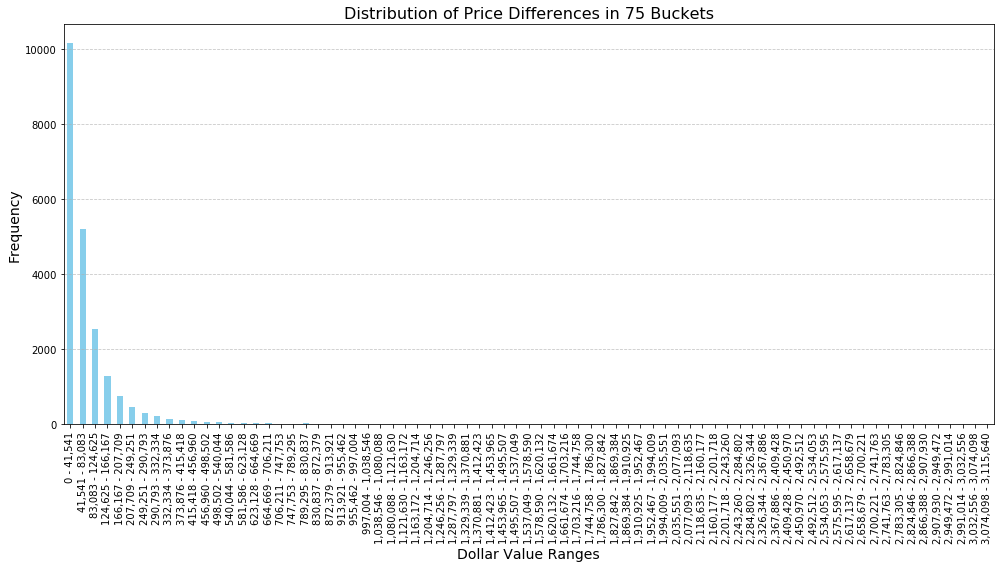

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bin the data
df = pd.DataFrame(data['price_diff_abs'], columns=['price_diff_abs'])

# Create bins
bins = np.linspace(data['price_diff_abs'].min(), data['price_diff_abs'].max(), 76)  # 30 intervals -> 31 bin edges
labels = [f"{int(bins[i]):,} - {int(bins[i+1]):,}" for i in range(len(bins)-1)]

# Bin the data
df = pd.DataFrame(data['price_diff_abs'], columns=['price_diff_abs'])
df['binned'] = pd.cut(df['price_diff_abs'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each bin
bin_counts = df['binned'].value_counts().sort_index()

# Plotting the binned data
plt.figure(figsize=(14, 8))
bin_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Price Differences in 75 Buckets', fontsize=16)
plt.xlabel('Dollar Value Ranges', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
import json
import pathlib
from typing import List, Tuple
import pickle

import pandas as pd
from sklearn import model_selection, pipeline, preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
import os
import datetime

def setup_mlflow():
    """Sets up MLflow to use SQLite as the backend store."""
    if not os.path.exists(DATABASE_PATH):
        # Automatically create the SQLite database if it doesn't exist
        with open(DATABASE_PATH, 'w'):
            pass

    # Set the tracking URI to the SQLite database
    mlflow.set_tracking_uri(f"sqlite:///{DATABASE_PATH}")

def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pd.DataFrame, pd.Series]:
    """Load the target and feature data by merging sales and demographics."""
    data = pd.read_csv(sales_path,
                       usecols=sales_column_selection,
                       dtype={'zipcode': str})
    demographics = pd.read_csv(demographics_path,
                               dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    
    y = merged_data.pop('price')
    x = merged_data

    return x, y

def main():
    """Load data, train model, and export artifacts."""
    # Set up MLflow with SQLite
    setup_mlflow()

    x, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, random_state=42)

    # Get the current date
    train_date = datetime.datetime.now().isoformat()

    # Start MLflow run
    with mlflow.start_run() as run:
        # Build the model pipeline
        model = pipeline.make_pipeline(
            preprocessing.RobustScaler(),
            RandomForestRegressor(n_estimators=100, random_state=42)
        ).fit(x_train, y_train)

        # Log model and parameters with MLflow
        mlflow.sklearn.log_model(model, "model")
        mlflow.log_params({
            "model_type": "RandomForestRegressor",
            "n_estimators": model.named_steps['randomforestregressor'].n_estimators,
            "max_depth": model.named_steps['randomforestregressor'].max_depth,
            "min_samples_split": model.named_steps['randomforestregressor'].min_samples_split,
            "min_samples_leaf": model.named_steps['randomforestregressor'].min_samples_leaf,
            "train_date": train_date
        })

        # Predict and evaluate on the test set
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        # Log metrics
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        r2_test = metrics.r2_score(y_test, y_pred_test)

        mlflow.log_metric("train_score", train_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("r2_test", r2_test)

        # Register the model and get the version
        mlflow.register_model(
            f"runs:/{run.info.run_id}/model",
            "HousePricePredictionModel"
        )
        
        # Save predictions to CSV
        full_data, prices = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
        preds = model.predict(full_data)
        full_data['pred_price'] = preds
        full_data['actual_price'] = prices
        full_data['price_diff'] = full_data['actual_price'] - full_data['pred_price']
        full_data['price_diff_abs'] = abs(full_data['actual_price'] - full_data['pred_price'])
        full_data.to_csv('data_w_preds_rfr.csv')

        # Output results
        print("train_score: ", train_score)
        print("test_score: ", test_score)
        print("mae: ", mae_test)
        print("mse: ", mse_test)
        print("r2: ", r2_test)

if __name__ == "__main__":
    main()

Registered model 'HousePricePredictionModel' already exists. Creating a new version of this model...
2024/08/19 16:53:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HousePricePredictionModel, version 10
Created version '10' of model 'HousePricePredictionModel'.


train_score:  0.9719593486888827
test_score:  0.7819736424054505
mae:  93753.31986349764
mse:  32614044871.461544
r2:  0.7819736424054505


In [52]:
main()

Registered model 'HousePricePredictionModel' already exists. Creating a new version of this model...
2024/08/19 16:54:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HousePricePredictionModel, version 11
Created version '11' of model 'HousePricePredictionModel'.


train_score:  0.9719593486888827
test_score:  0.7819736424054505
mae:  93753.31986349764
mse:  32614044871.461544
r2:  0.7819736424054505


In [53]:
import json
import pathlib
from typing import List, Tuple
import pickle

import pandas as pd
from sklearn import model_selection, pipeline, preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
import os
import datetime

def setup_mlflow():
    """Sets up MLflow to use SQLite as the backend store."""
    if not os.path.exists(DATABASE_PATH):
        # Automatically create the SQLite database if it doesn't exist
        with open(DATABASE_PATH, 'w'):
            pass

    # Set the tracking URI to the SQLite database
    mlflow.set_tracking_uri(f"sqlite:///{DATABASE_PATH}")

def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pd.DataFrame, pd.Series]:
    """Load the target and feature data by merging sales and demographics."""
    data = pd.read_csv(sales_path,
                       usecols=sales_column_selection,
                       dtype={'zipcode': str})
    demographics = pd.read_csv(demographics_path,
                               dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    
    y = merged_data.pop('price')
    x = merged_data

    return x, y

def preprocess_data(x: pd.DataFrame) -> pd.DataFrame:
    """Preprocess data by one-hot encoding specific columns."""
    # One-hot encode the specified columns
    x_encoded = pd.get_dummies(x, columns=['bedrooms', 'bathrooms', 'floors'], drop_first=True)
    return x_encoded

def main():
    """Load data, train model, and export artifacts."""
    # Set up MLflow with SQLite
    setup_mlflow()

    x, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
    
    # Preprocess data (one-hot encode specific columns)
    x = preprocess_data(x)
    
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, random_state=42)

    # Get the current date
    train_date = datetime.datetime.now().isoformat()

    # Start MLflow run
    with mlflow.start_run() as run:
        # Build the model pipeline
        model = pipeline.make_pipeline(
            preprocessing.RobustScaler(),
            RandomForestRegressor(n_estimators=100, random_state=42)
        ).fit(x_train, y_train)

        # Log model and parameters with MLflow
        mlflow.sklearn.log_model(model, "model")
        mlflow.log_params({
            "model_type": "RandomForestRegressor",
            "n_estimators": model.named_steps['randomforestregressor'].n_estimators,
            "max_depth": model.named_steps['randomforestregressor'].max_depth,
            "min_samples_split": model.named_steps['randomforestregressor'].min_samples_split,
            "min_samples_leaf": model.named_steps['randomforestregressor'].min_samples_leaf,
            "train_date": train_date
        })

        # Predict and evaluate on the test set
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        # Log metrics
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        r2_test = metrics.r2_score(y_test, y_pred_test)

        mlflow.log_metric("train_score", train_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("r2_test", r2_test)

        # Register the model and get the version
        mlflow.register_model(
            f"runs:/{run.info.run_id}/model",
            "HousePricePredictionModel"
        )
        
        # Save predictions to CSV
        full_data, prices = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
        full_data = preprocess_data(full_data)
        preds = model.predict(full_data)
        full_data['pred_price'] = preds
        full_data['actual_price'] = prices
        full_data['price_diff'] = full_data['actual_price'] - full_data['pred_price']
        full_data['price_diff_abs'] = abs(full_data['actual_price'] - full_data['pred_price'])
        full_data.to_csv('data_w_preds_rfr_ohe.csv')

        # Output results
        print("train_score: ", train_score)
        print("test_score: ", test_score)
        print("mae: ", mae_test)
        print("mse: ", mse_test)
        print("r2: ", r2_test)

if __name__ == "__main__":
    main()


Registered model 'HousePricePredictionModel' already exists. Creating a new version of this model...
2024/08/19 16:58:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HousePricePredictionModel, version 12
Created version '12' of model 'HousePricePredictionModel'.


train_score:  0.9717441592994376
test_score:  0.7828305770236895
mae:  93601.44803988522
mse:  32485858057.72259
r2:  0.7828305770236895


In [54]:
main()

Registered model 'HousePricePredictionModel' already exists. Creating a new version of this model...
2024/08/19 16:58:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HousePricePredictionModel, version 13
Created version '13' of model 'HousePricePredictionModel'.


train_score:  0.9717441592994376
test_score:  0.7828305770236895
mae:  93601.44803988522
mse:  32485858057.72259
r2:  0.7828305770236895


In [56]:
import json
import pathlib
from typing import List, Tuple
import pickle

import pandas as pd
from sklearn import model_selection, pipeline, preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import os
import datetime

def setup_mlflow():
    """Sets up MLflow to use SQLite as the backend store."""
    if not os.path.exists(DATABASE_PATH):
        # Automatically create the SQLite database if it doesn't exist
        with open(DATABASE_PATH, 'w'):
            pass

    # Set the tracking URI to the SQLite database
    mlflow.set_tracking_uri(f"sqlite:///{DATABASE_PATH}")

def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pd.DataFrame, pd.Series]:
    """Load the target and feature data by merging sales and demographics."""
    data = pd.read_csv(sales_path,
                       usecols=sales_column_selection,
                       dtype={'zipcode': str})
    demographics = pd.read_csv(demographics_path,
                               dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    
    y = merged_data.pop('price')
    x = merged_data

    return x, y

def preprocess_data(x: pd.DataFrame) -> pd.DataFrame:
    """Preprocess data by one-hot encoding specific columns."""
    # One-hot encode the specified columns
    x_encoded = pd.get_dummies(x, columns=['bedrooms', 'bathrooms', 'floors'], drop_first=True)
    return x_encoded

def main():
    """Load data, train model with Grid Search, and export artifacts."""
    # Set up MLflow with SQLite
    setup_mlflow()

    x, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
    
    # Preprocess data (one-hot encode specific columns)
    x = preprocess_data(x)
    
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, random_state=42)

    # Get the current date
    train_date = datetime.datetime.now().isoformat()

    # Define the model pipeline
    model_pipeline = pipeline.make_pipeline(
        preprocessing.RobustScaler(),
        RandomForestRegressor(random_state=42)
    )

    # Define the parameter grid for Grid Search
    param_grid = {
        'randomforestregressor__n_estimators': [100, 200, 300],
        'randomforestregressor__max_depth': [None, 10, 20, 30],
        'randomforestregressor__min_samples_split': [2, 5, 10],
        'randomforestregressor__min_samples_leaf': [1, 2, 4],
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2']
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_

    # Start MLflow run
    with mlflow.start_run() as run:
        # Log best model and parameters with MLflow
        mlflow.sklearn.log_model(best_model, "model")
        mlflow.log_params({
            "model_type": "RandomForestRegressor",
            "n_estimators": best_model.named_steps['randomforestregressor'].n_estimators,
            "max_depth": best_model.named_steps['randomforestregressor'].max_depth,
            "min_samples_split": best_model.named_steps['randomforestregressor'].min_samples_split,
            "min_samples_leaf": best_model.named_steps['randomforestregressor'].min_samples_leaf,
            "max_features": best_model.named_steps['randomforestregressor'].max_features,
            "train_date": train_date
        })

        # Predict and evaluate on the test set
        y_pred_train = best_model.predict(x_train)
        y_pred_test = best_model.predict(x_test)

        # Log metrics
        train_score = best_model.score(x_train, y_train)
        test_score = best_model.score(x_test, y_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        r2_test = metrics.r2_score(y_test, y_pred_test)

        mlflow.log_metric("train_score", train_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("r2_test", r2_test)

        # Register the model and get the version
        mlflow.register_model(
            f"runs:/{run.info.run_id}/model",
            "HousePricePredictionModel"
        )
        
        # Save predictions to CSV
        full_data, prices = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
        full_data = preprocess_data(full_data)
        preds = best_model.predict(full_data)
        full_data['pred_price'] = preds
        full_data['actual_price'] = prices
        full_data['price_diff'] = full_data['actual_price'] - full_data['pred_price']
        full_data['price_diff_abs'] = abs(full_data['actual_price'] - full_data['pred_price'])
        #full_data.to_csv('data_w_preds.csv')

        # Output results
        print("Best Parameters: ", grid_search.best_params_)
        print("train_score: ", train_score)
        print("test_score: ", test_score)
        print("mae: ", mae_test)
        print("mse: ", mse_test)
        print("r2: ", r2_test)

if __name__ == "__main__":
    main()


Fitting 3 folds for each of 324 candidates, totalling 972 fits


Registered model 'HousePricePredictionModel' already exists. Creating a new version of this model...
2024/08/19 17:48:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: HousePricePredictionModel, version 15
Created version '15' of model 'HousePricePredictionModel'.


Best Parameters:  {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 300}
train_score:  0.9199412092373745
test_score:  0.7917113658195405
mae:  92023.80663505134
mse:  31157401959.673748
r2:  0.7917113658195405


In [ ]:
main()